<a href="https://colab.research.google.com/github/Prakhar314/COL764-Project/blob/main/pairwise_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers tensorflow-addons

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Model

In [2]:
import transformers
from transformers import BertTokenizer, BertConfig, TFBertModel
import tensorflow as tf
import tensorflow_addons as tfa

ModuleNotFoundError: ignored

In [ ]:
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

#### Pointwise

In [ ]:
def create_inputs(num_nodes,name):
  layers = []
  for layer_name in ['input_ids','token_type_ids','attention_mask']:
    layers.append(tf.keras.layers.Input(shape=(num_nodes,),dtype=tf.int32,name=layer_name+f'_{name}'))
  return layers

def create_model_pairwise(output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    config = BertConfig(hidden_dropout_prob=0.1)
    bert = TFBertModel.from_pretrained(bert_model_name,config=config)
    bert.save_pretrained('./bert-model/')
    for layer in bert.layers[:]:
      if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        layer.embeddings.trainable=False
        layer.pooler.trainable=False
        for idx, layer in enumerate(layer.encoder.layer):
            # print(layer)
            # freeze first 10
            if idx in range(10):
                layer.trainable = False
      else:
        layer.trainable = False
              
    input_1 = create_inputs(512,'pair_1')
    input_2 = create_inputs(512,'pair_2')
    bert_out_1 = bert(input_1).last_hidden_state
    bert_out_2 = bert(input_2).last_hidden_state
    cls_1 = tf.keras.layers.Lambda(lambda x:x[:,0,:])(bert_out_1)
    cls_2 = tf.keras.layers.Lambda(lambda x:x[:,0,:])(bert_out_2)
    concated = tf.keras.layers.Concatenate()([cls_1,cls_2])
    # print(avg_q.shape)
    output = tf.keras.layers.Dense(1, activation="sigmoid",bias_initializer=output_bias)(concated)
    model = tf.keras.models.Model(inputs=[input_1,input_2], outputs=[output])
    # opt,schedule = transformers.create_optimizer(num_train_steps=num_train_steps,init_lr=3e-5,adam_beta1=0.9,adam_beta2=0.999,weight_decay_rate=0.01,num_warmup_steps=num_train_steps//10)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.AUC(curve="ROC")])
    model.summary()
    return model

#### Load Weights

In [ ]:
model = create_model_pairwise()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_pair_1 (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids_pair_1 (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                                  
 attention_mask_pair_1 (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                              

In [ ]:
model.load_weights("/content/gdrive/MyDrive/col764/final_model_pairwise.h5")

### Load Data

In [3]:
!tar -zxf /content/gdrive/MyDrive/col764/output_qrel_only.tar.gz

In [4]:
!ls /content/gdrive/MyDrive/col764/results

run.desc.test.txt   run.query.test.txt		 run.query.train.txt
run.desc.train.txt  run.query.test.txt.reranked


In [5]:
import os

In [6]:
import pandas as pd

In [7]:
query_file = '/content/gdrive/MyDrive/col764/queries/podcasts_2020_topics_test_query.tsv'

In [8]:
queries = pd.read_csv(query_file,sep='\t',header=None)
queries.columns = ['qnum','query']

In [9]:
queries

,qnum,query
0,9,trump call ukrainian president
1,10,boeing 737 crash causes
2,11,how to cook turkey
3,12,imran khan career
4,13,drug addiction recovery
5,14,near death experiences
6,15,podcast about podcasts
7,16,causes and prevention of wildfires
8,17,time between meetings
9,18,women in stem


In [10]:
results_file = '/content/gdrive/MyDrive/col764/results/run.query.test.txt'

In [11]:
bm25_ranks = pd.read_csv(results_file,sep=' ',header=None)
bm25_ranks.columns = ['qnum','qid','epid','rank','score','runid']

In [12]:
bm25_ranks

,qnum,qid,epid,rank,score,runid
0,9,Q0,spotify:episode:6O8djf3RL94yNfaoWqvk3r_840.0,1,16.569401,Anserini
1,9,Q0,spotify:episode:3gJ0fBXYRryWAjgwxY4q6C_240.0,2,16.302999,Anserini
2,9,Q0,spotify:episode:6svv5L5kRn8groSsM8gkpc_3180.0,3,15.984800,Anserini
3,9,Q0,spotify:episode:4JqqVFhNjtlwoIMl5tvL8R_780.0,4,15.275800,Anserini
4,9,Q0,spotify:episode:3gJ0fBXYRryWAjgwxY4q6C_0.0,5,14.734600,Anserini
...,...,...,...,...,...,...
47753,58,Q0,spotify:episode:30j4F0dABykbXJuGevrfNB_1920.0,996,4.663695,Anserini
47754,58,Q0,spotify:episode:3ALoC0SU00c8RtxQHohesZ_1440.0,997,4.663694,Anserini
47755,58,Q0,spotify:episode:3ALoC0SU00c8RtxQHohesZ_420.0,998,4.663693,Anserini
47756,58,Q0,spotify:episode:3bieaciVail62osQ0YC8JE_1380.0,999,4.663692,Anserini


In [13]:
bm25_ranks = bm25_ranks[bm25_ranks['rank']<21].reset_index(drop=True)

In [14]:
episode_contents = {k:None for k in bm25_ranks.epid.unique()}

In [15]:
!ls /content/

gdrive	output_copy  sample_data


In [16]:
import json
for root, dirs, files in os.walk('/content/output_copy'):
  files.sort()
  for file in files:
    # print(file)
    with open(root+"/"+file,'r') as f:
      episode_segments = json.load(f)
      for segment in episode_segments:
        if segment['id'] in episode_contents:
          episode_contents[segment['id']] = segment['contents']

In [17]:
len(sorted(list(episode_contents.keys())))

1000

In [18]:
bm25_ranks['segment'] = bm25_ranks['epid'].map(episode_contents)

In [19]:
bm25_ranks=bm25_ranks.merge(queries,how='left',left_on='qnum',right_on='qnum')

In [20]:
bm25_ranks = bm25_ranks.merge(bm25_ranks[['qnum','segment','epid']],how='left',left_on='qnum',right_on='qnum')

Distribution of token sizes

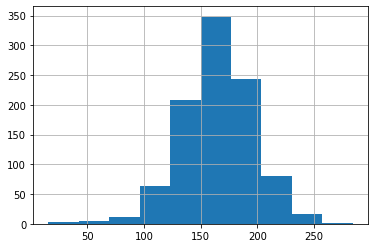

In [41]:
pd.DataFrame(bm25_ranks['segment_y'].unique()).apply(lambda x:len(x[0].split()),axis=1).hist()

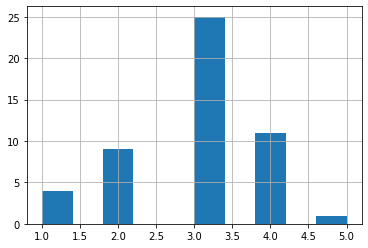

In [42]:
pd.DataFrame(bm25_ranks['query'].unique()).apply(lambda x:len(x[0].split()),axis=1).hist()

### Reranking

In [ ]:
q_trunc = 64
p_trunc = 512-64+1

In [ ]:
import gc
import numpy as np

In [ ]:
q = tokenizer(bm25_ranks['query'].values.tolist(), return_tensors="tf",padding="max_length",max_length=q_trunc,truncation=True)
p_1 = tokenizer(bm25_ranks['segment_x'].values.tolist(), return_tensors="tf",padding="max_length",max_length=p_trunc,truncation=True)
p_2 = tokenizer(bm25_ranks['segment_y'].values.tolist(), return_tensors="tf",padding="max_length",max_length=p_trunc,truncation=True)
X_test = []
for id in ['input_ids','token_type_ids','attention_mask']:
  X_test.append(tf.concat([q[id],p_1[id][:,1:]],1))
for id in ['input_ids','token_type_ids','attention_mask']:
  X_test.append(tf.concat([q[id],p_2[id][:,1:]],1))
q = None
p_1 = None
p_2 = None
gc.collect()

0

In [ ]:
scores = model.predict(X_test,batch_size=8,verbose=1)

2500/2500 [==============================] - 2983s 1s/step


#### Scores to rank

In [ ]:
bm25_ranks['score'] = scores

In [ ]:
bm25_ranks = bm25_ranks.drop(['segment_x','segment_y','query'],axis=1)

In [ ]:
def getRanks(results):
  pivot = results.pivot('epid_x','epid_y','score')
  pivot_t = pivot.T
  np.fill_diagonal(pivot.values,1)
  results_ranked = pd.DataFrame((pivot>pivot_t).sum(axis=1) + pivot.mean(axis=1))
  results_ranked = results_ranked.reset_index()
  dropped = results.drop(['epid_y','score'],axis=1).drop_duplicates()
  results_ranked = results_ranked.merge(dropped,how='left',left_on='epid_x',right_on='epid_x')
  results_ranked.columns = ['epid','score','qnum','qid','rank','runid']
  return results_ranked

In [ ]:
bm25_ranks = bm25_ranks.groupby('qnum').apply(getRanks).reset_index(drop=True)
bm25_ranks[['rank','qnum']] = bm25_ranks[['rank','qnum']].astype(np.int32)
bm25_ranks

,epid,score,qnum,qid,rank,runid
0,spotify:episode:0DNqe9Rnj8gP0fRCOsWxfT_1440.0,7.480740,9,Q0,16,Anserini
1,spotify:episode:0nhWyQfESIgR4X8nQZa08y_1980.0,3.258539,9,Q0,20,Anserini
2,spotify:episode:14RFTGKJ9RQlxtJJ6MhNXs_300.0,10.590264,9,Q0,7,Anserini
3,spotify:episode:1jvy4Usn4Z8awRi3gpw0iQ_900.0,17.899696,9,Q0,17,Anserini
4,spotify:episode:1nu9RsgfYsbNb7CDmHlvKx_1320.0,16.855876,9,Q0,8,Anserini
...,...,...,...,...,...,...
995,spotify:episode:5xDfrpC4pmkHBVf28JYKv1_120.0,3.244529,58,Q0,14,Anserini
996,spotify:episode:62DJcqXZ65VsObZPkv4ZIJ_4140.0,16.859750,58,Q0,20,Anserini
997,spotify:episode:73jHKrU0ZDmI2SNCsYyCsz_2160.0,18.928263,58,Q0,4,Anserini
998,spotify:episode:76ezvYdkEkPsWO5x5PwUjz_5100.0,4.276828,58,Q0,12,Anserini


In [ ]:
bm25_ranks = bm25_ranks.sort_values(['qnum','score'], ascending = [True, False]).reset_index(drop=True)

In [ ]:
bm25_ranks['rank'] = bm25_ranks.groupby('qnum')['score'].rank(ascending=False).astype(np.int16)

In [ ]:
bm25_ranks = bm25_ranks[['qnum',	'qid',	'epid',	'rank',	'score',	'runid']]
bm25_ranks

,qnum,qid,epid,rank,score,runid
0,9,Q0,spotify:episode:4JqqVFhNjtlwoIMl5tvL8R_780.0,1,19.972418,Anserini
1,9,Q0,spotify:episode:3gJ0fBXYRryWAjgwxY4q6C_0.0,2,18.926608,Anserini
2,9,Q0,spotify:episode:1jvy4Usn4Z8awRi3gpw0iQ_900.0,3,17.899696,Anserini
3,9,Q0,spotify:episode:1nu9RsgfYsbNb7CDmHlvKx_1320.0,4,16.855876,Anserini
4,9,Q0,spotify:episode:2wlZZPXaCiEBGB0TCPk7VL_780.0,5,15.788488,Anserini
...,...,...,...,...,...,...
995,58,Q0,spotify:episode:76ezvYdkEkPsWO5x5PwUjz_5100.0,16,4.276828,Anserini
996,58,Q0,spotify:episode:5xDfrpC4pmkHBVf28JYKv1_120.0,17,3.244529,Anserini
997,58,Q0,spotify:episode:7pECOFSfCit9J2ZIvPDNMm_0.0,18,2.258043,Anserini
998,58,Q0,spotify:episode:4oPXTfrAk9nq7gxWl6zkuY_360.0,19,1.173298,Anserini


In [ ]:
bm25_ranks.to_csv(results_file+'.reranked', sep = '\t', index=False)

In [ ]:
!git clone https://github.com/usnistgov/trec_eval

fatal: destination path 'trec_eval' already exists and is not an empty directory.


In [ ]:
!cd trec_eval;make

make: 'trec_eval' is up to date.


In [ ]:
!./trec_eval/trec_eval  -q -c -M1000 -m ndcg_cut.10 /content/gdrive/MyDrive/col764/qrels/2020_test_qrels.list {results_file}.reranked

ndcg_cut_10           	10	0.3638
ndcg_cut_10           	11	0.1257
ndcg_cut_10           	12	0.2042
ndcg_cut_10           	13	0.0000
ndcg_cut_10           	14	0.6687
ndcg_cut_10           	15	0.0620
ndcg_cut_10           	16	0.2415
ndcg_cut_10           	17	0.0636
ndcg_cut_10           	18	0.3152
ndcg_cut_10           	19	0.5967
ndcg_cut_10           	20	0.3674
ndcg_cut_10           	21	0.4645
ndcg_cut_10           	22	0.3396
ndcg_cut_10           	23	0.0386
ndcg_cut_10           	24	0.7772
ndcg_cut_10           	25	0.5022
ndcg_cut_10           	26	0.5501
ndcg_cut_10           	27	0.3464
ndcg_cut_10           	28	0.6111
ndcg_cut_10           	29	0.6423
ndcg_cut_10           	30	0.0698
ndcg_cut_10           	31	0.0000
ndcg_cut_10           	32	0.0980
ndcg_cut_10           	33	0.2787
ndcg_cut_10           	34	0.0941
ndcg_cut_10           	35	0.1914
ndcg_cut_10           	36	0.4020
ndcg_cut_10           	37	0.1500
ndcg_cut_10           	38	0.6880
ndcg_cut_10           	39	0.1790
ndcg_cut_1

In [ ]:
!./trec_eval/trec_eval  -q -c -m ndcg_cut.10  /content/gdrive/MyDrive/col764/qrels/2020_test_qrels.list {results_file}

ndcg_cut_10           	10	0.7417
ndcg_cut_10           	11	0.2351
ndcg_cut_10           	12	0.2562
ndcg_cut_10           	13	0.0979
ndcg_cut_10           	14	0.6778
ndcg_cut_10           	15	0.0568
ndcg_cut_10           	16	0.1587
ndcg_cut_10           	17	0.0694
ndcg_cut_10           	18	0.1443
ndcg_cut_10           	19	0.6888
ndcg_cut_10           	20	0.5237
ndcg_cut_10           	21	0.4987
ndcg_cut_10           	22	0.1936
ndcg_cut_10           	23	0.0807
ndcg_cut_10           	24	0.4212
ndcg_cut_10           	25	0.5670
ndcg_cut_10           	26	0.6419
ndcg_cut_10           	27	0.5210
ndcg_cut_10           	28	0.6111
ndcg_cut_10           	29	0.7128
ndcg_cut_10           	30	0.1138
ndcg_cut_10           	31	0.0000
ndcg_cut_10           	32	0.1091
ndcg_cut_10           	33	0.2867
ndcg_cut_10           	34	0.2077
ndcg_cut_10           	35	0.3097
ndcg_cut_10           	36	0.5705
ndcg_cut_10           	37	0.2247
ndcg_cut_10           	38	0.7711
ndcg_cut_10           	39	0.3954
ndcg_cut_1

In [ ]:
!ls /content/gdrive/MyDrive/col764/results/

run.desc.test.txt   run.query.test.txt		 run.query.train.txt
run.desc.train.txt  run.query.test.txt.reranked
